In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>")) 

In [4]:
#Import libs
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
import librosa
import librosa.display
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [5]:
dataset_path = 'D:\Masters\CS 6375 - Machine Learning\Sem1_project\TESS'

In [6]:
paths = []
labels = []
for dir_, _, files in os.walk(dataset_path):
    for file in files:
        paths.append(os.path.join(dir_,file))
        labels.append(file.lower().split('_')[-1].split('.')[0])
        #print(file)
        
        
#print(labels)
print(len(labels))
#print(paths)
#print(len(paths))

2800


In [7]:
#Showing a sample of the dataframe
df = pd.DataFrame()
df['filepath'] = paths
df['label'] = labels
df.sample(5)

,filepath,label
1613,D:\Masters\CS 6375 - Machine Learning\Sem1_pro...,disgust
2564,D:\Masters\CS 6375 - Machine Learning\Sem1_pro...,ps
105,D:\Masters\CS 6375 - Machine Learning\Sem1_pro...,angry
1743,D:\Masters\CS 6375 - Machine Learning\Sem1_pro...,disgust
2155,D:\Masters\CS 6375 - Machine Learning\Sem1_pro...,happy


In [8]:
df['label'].value_counts()

angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: label, dtype: int64

<AxesSubplot: xlabel='label', ylabel='count'>

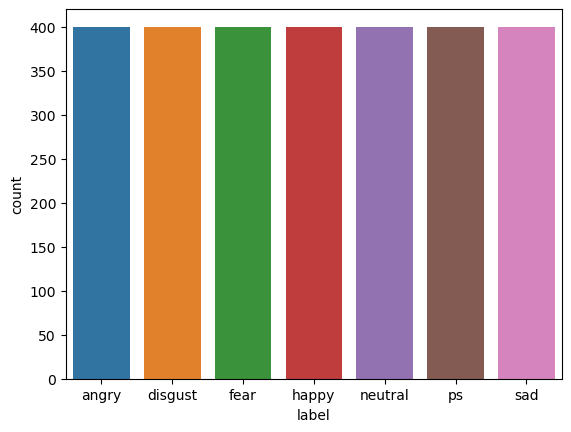

In [54]:
#EDA
sns.countplot(x=df['label'], data = df)

In [9]:
#Helper functions
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr, color="blue")
    plt.show()
    
def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(xdb, sr=sr, color="blue")
    plt.colorbar()
    
def plot_signals(signals):
    fig,axes = plt.subplots(nrows=2,ncols=5, sharex=False, sharey=True, figsize=(20,5))
    
    fig.suptitle("Time Series",size=16)
    i=0
    for x in range(2):
        for y in range(5):
            if((x+1)*(y+1)<=5):
                axes[x,y].set_title(list(signals.keys())[i])
                axes[x,y].plot(list(signals.values())[i])
                axes[x,y].get_xaxis().set_visible(False)
                axes[x,y].get_yaxis().set_visible(False)
                i += 1
            else:
                fig.delaxes(axes[x,y])

def plot_fft(fft):
    fig,axes = plt.subplots(nrows=2,ncols=5, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle("Fourier Transforms",size=16)
    i=0
    for x in range(2):
        for y in range(5):
            if((x+1)*(y+1)<=5):
                data = list(fft.values())[i]
                Y, freq = data[0], data[1]
                axes[x,y].set_title(list(fft.keys())[i])
                axes[x,y].plot(freq,Y)
                axes[x,y].get_xaxis().set_visible(False)
                axes[x,y].get_yaxis().set_visible(False)
                i += 1
            else:
                fig.delaxes(axes[x,y])
                
def plot_fbank(fbank):
    fig,axes = plt.subplots(nrows=2,ncols=5, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle("Filter Bank Coefficients",size=16)
    i=0
    for x in range(2):
        for y in range(5):
            if((x+1)*(y+1)<=5):
                axes[x,y].set_title(list(fbank.keys())[i])
                axes[x,y].imshow(list(fbank.values())[i], cmap='hot', interpolation='nearest')
                axes[x,y].get_xaxis().set_visible(False)
                axes[x,y].get_yaxis().set_visible(False)
                i += 1
            else:
                fig.delaxes(axes[x,y])
def plot_mfccs(mfccs):
    fig,axes = plt.subplots(nrows=2,ncols=5, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle("Mel Frequency Cepstrum Coefficients",size=16)
    i=0
    for x in range(2):
        for y in range(5):
            if((x+1)*(y+1)<=5):
                axes[x,y].set_title(list(mfccs.keys())[i])
                axes[x,y].imshow(list(mfccs.values())[i], cmap='hot', interpolation='nearest')
                axes[x,y].get_xaxis().set_visible(False)
                axes[x,y].get_yaxis().set_visible(False)
                i += 1
            else:
                fig.delaxes(axes[x,y])
                
def envelop(y,rate,threshold):
    mask=[]
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(0.1*rate), min_periods=1,center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
            
    return mask
    
    
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n,d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y,freq)

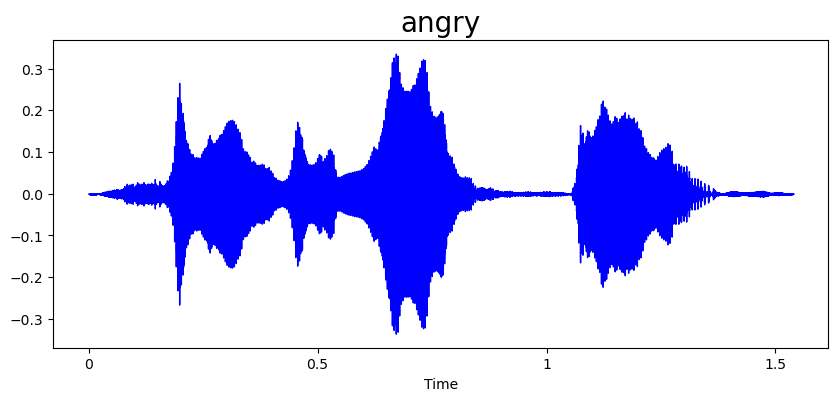

In [10]:
#Showing the waveform of a random audiofile
emotion = 'angry'
path = df.loc[df['label']==emotion, 'filepath'].iloc[0]
data, sampling_rate = librosa.load(path)

waveplot(data, sampling_rate, emotion)
#spectrogram(data, sampling_rate, emotion)
Audio(path)

In [13]:
#Loading all the audiofiles

data = df.set_index('filepath')

for f in tqdm(data.index):
    #print(f)
    signal, rate= librosa.load(f)
    data.at[f, 'length'] = signal.shape[0]/rate

100%|██████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:32<00:00, 85.78it/s]


In [14]:
data.sample(5)

,label,length
filepath,,
D:\Masters\CS 6375 - Machine Learning\Sem1_project\TESS Toronto emotional speech set data\YAF_pleasant_surprised\YAF_shirt_ps.wav,ps,2.027664
D:\Masters\CS 6375 - Machine Learning\Sem1_project\TESS Toronto emotional speech set data\YAF_fear\YAF_pool_fear.wav,fear,1.421497
D:\Masters\CS 6375 - Machine Learning\Sem1_project\TESS Toronto emotional speech set data\YAF_neutral\YAF_white_neutral.wav,neutral,2.161315
D:\Masters\CS 6375 - Machine Learning\Sem1_project\TESS Toronto emotional speech set data\OAF_Sad\OAF_puff_sad.wav,sad,2.347211
D:\Masters\CS 6375 - Machine Learning\Sem1_project\TESS Toronto emotional speech set data\YAF_sad\YAF_perch_sad.wav,sad,2.556780


In [15]:
classes = list(np.unique(data.label))
class_dist = data.groupby(['label'])['length'].mean()
class_dist

label
angry      1.841400
disgust    2.448567
fear       1.658664
happy      1.972958
neutral    2.054532
ps         2.007800
sad        2.402116
Name: length, dtype: float64

In [55]:
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']

In [16]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in tqdm(classes):
    wav_file = df[df.label == c].iloc[0,0]
    signal, rate = librosa.load(wav_file,sr=44100)
    mask = envelop(signal,rate,0.005) #removing deadspace in the audio by creating an envelop
    signal = signal[mask]
    signals[c] = signal
    #Extracting features
    fft[c] = calc_fft(signal, rate)
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T #44100/40
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.38it/s]


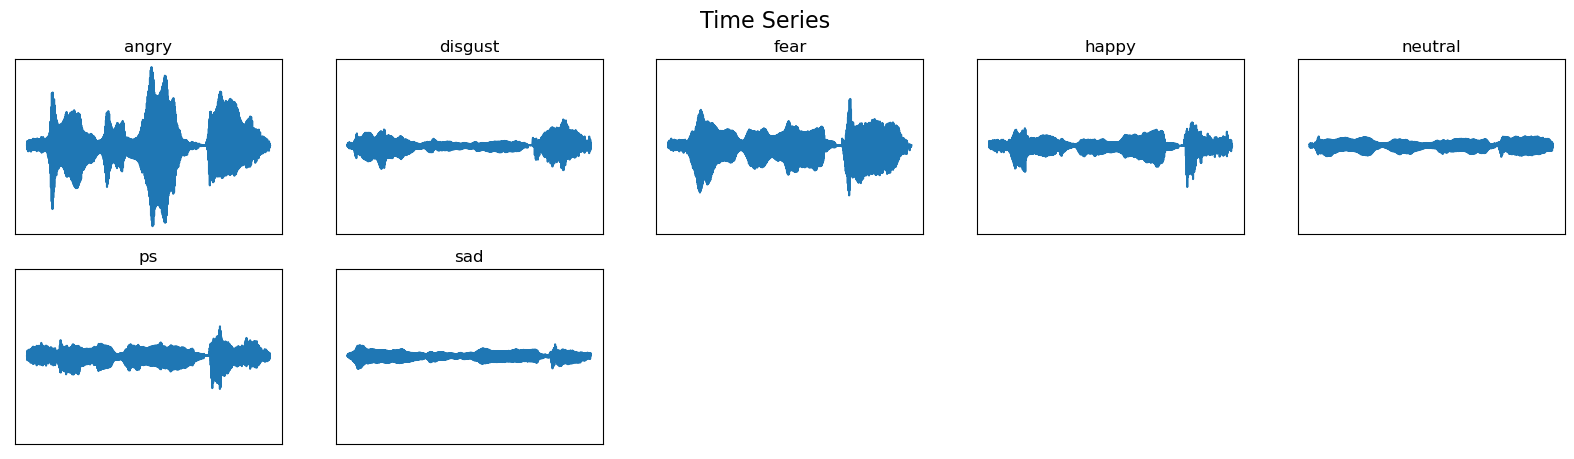

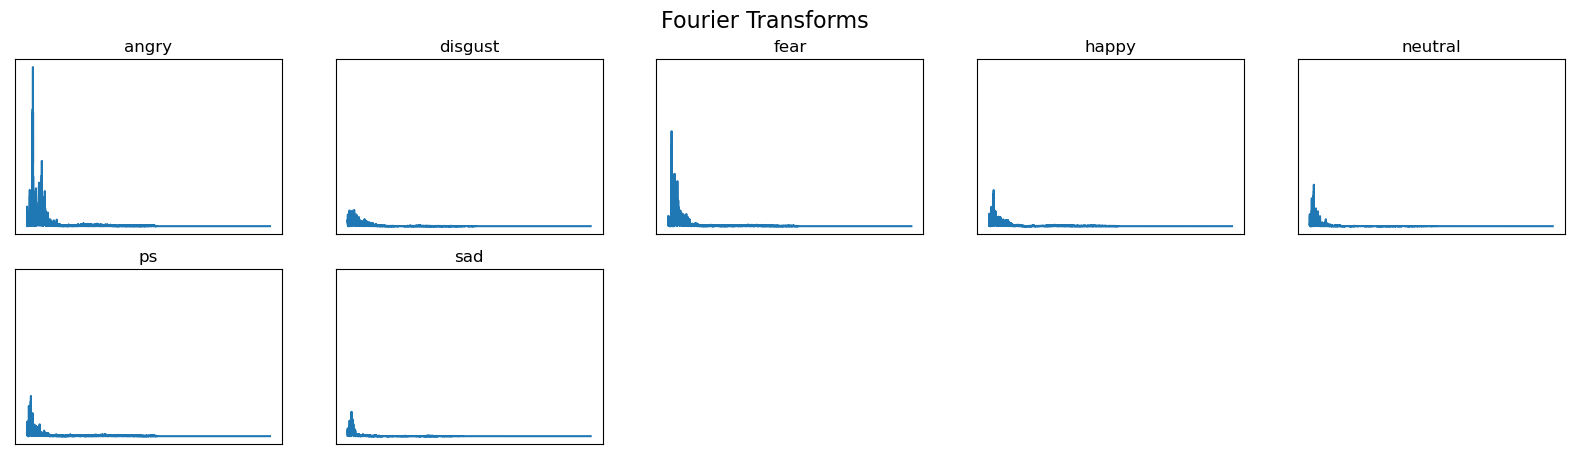

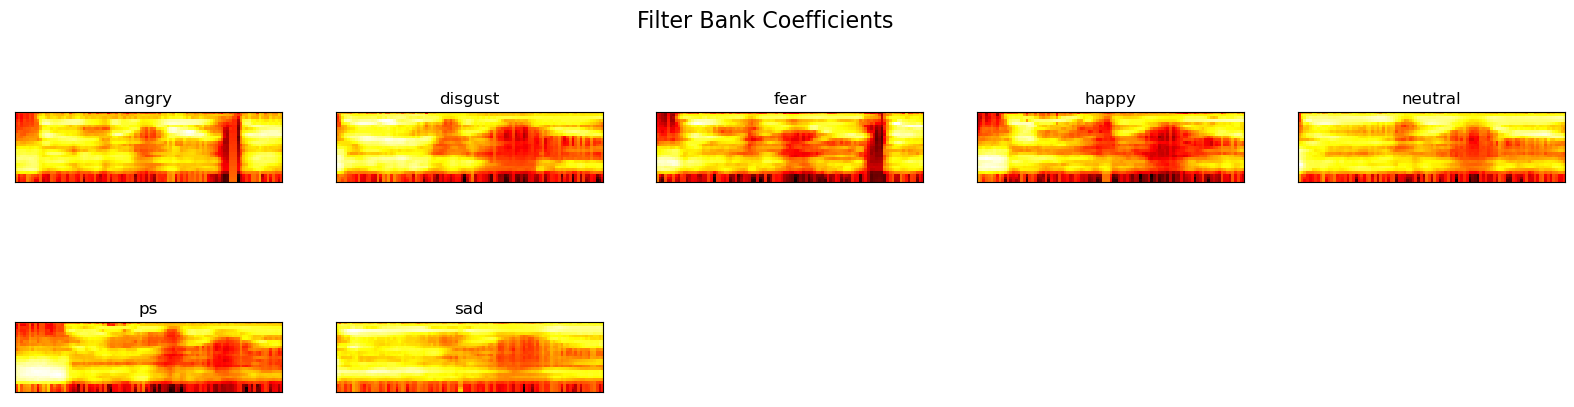

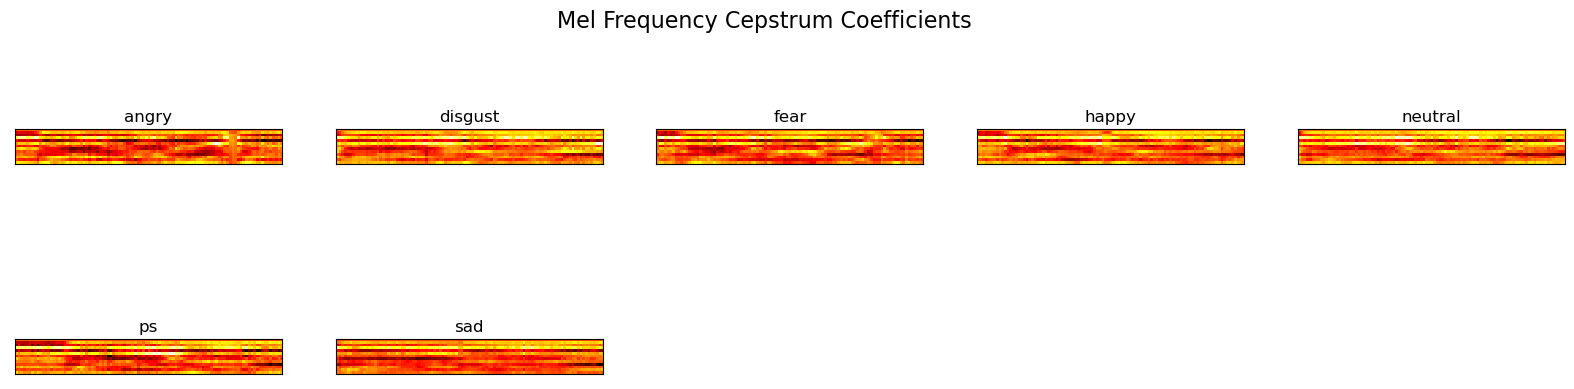

In [17]:
plot_signals(signals)
plot_fft(fft)
plot_fbank(fbank)
plot_mfccs(mfccs)
plt.show()

In [18]:
df

,filepath,label
0,D:\Masters\CS 6375 - Machine Learning\Sem1_pro...,angry
1,D:\Masters\CS 6375 - Machine Learning\Sem1_pro...,angry
2,D:\Masters\CS 6375 - Machine Learning\Sem1_pro...,angry
3,D:\Masters\CS 6375 - Machine Learning\Sem1_pro...,angry
4,D:\Masters\CS 6375 - Machine Learning\Sem1_pro...,angry
...,...,...
2795,D:\Masters\CS 6375 - Machine Learning\Sem1_pro...,sad
2796,D:\Masters\CS 6375 - Machine Learning\Sem1_pro...,sad
2797,D:\Masters\CS 6375 - Machine Learning\Sem1_pro...,sad
2798,D:\Masters\CS 6375 - Machine Learning\Sem1_pro...,sad


In [19]:
if len(os.listdir('clean'))==0:
    for f in tqdm(df.filepath):
        signal, rate =  librosa.load(f,sr=16000)
        mask = envelop(signal, rate, 0.005)
        wavfile.write(filename='clean\\'+f.split("\\")[-1], rate=rate, data=signal[mask]) #Copying the processsed clean audiofiles into another folder